In [2]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
#The spacetime parameters. Let the population distribution of gene expression level be g:
g_min = 0
g_max = 100
dg = 0.4
#Defining a g_ghost which contains two extra `ghost' points at the edges:
g_ghost = np.arange(g_min-dg,g_max+2*dg,dg)
g = np.array(g_ghost[1:-1])


#Time:
dt = 0.00016
T = 20
Nt = int(T/dt)
TimeRange = np.arange(0,T,dt)

#How the population distributions evolve in the absence of selection. First, we define the free parameters...
#...K and alpha, and from those D. K sets the timescale of population response to the regulated mean...
#...which is set instantaneously. We may choose time units such that K=1.
K = 1
#The strength of noise:
alpha = 5
#The spread, with the preferred expression level (peak) now set to 50% of maximum.:
g_peak = 0.5*(g_min+g_max)
D = alpha*K*g_peak

#Checks:
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")
    
#Now let's add selection to the picture. First, defining the relative differential growth rate delta. We multiply this by 0.17/g_max to get Dekel delta.
delta = .17/g_max

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

K = 1; 0.5*dg/dt = 1250.0
D = 250.0; 0.5*dg**2/dt = 500.00000000000006


In [10]:
#First derivative, central difference method (used in the potential term K*d/dg (g*P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv1(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    #Below we calculate the first derivative using the central difference method:
    derivative = (func_right - func_left)/(2*dx)
    return derivative

#Second derivative using central difference, used in the diffusion term (D*d2/dg2 (P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv2(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    func_center = func[1:-1]
    #Below we calculate the second derivative, again using central difference method:
    derivative2 = (func_right + func_left - 2*func_center)/(dx**2)
    return derivative2

#Defining a Gaussian pdf - we'll need it for P(g,t=0), the initial distribution:
@jit(nopython=True)
def Gaussian(x,mu,sigma):
    dist = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)
    return dist

#The function to calculate <f> dynamically, i.e. int_g f(g,s) P(g,t):
@jit(nopython=True)
def mean_wrt_P(func,P,g):
    integrand = func*P
    integral = np.trapz(integrand,g)
    return integral

#Defining the fitness function:
# @jit(["float64[:](float64[:],float64,float64)","float64(float64,float64,float64)"],nopython=True)
def fitness(g,s,delta):
#     fit = delta*((.17/g_max)*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max))) + 1)
    return delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))

#Putting the solver inside a function:
# @jit("float64[:,:](float64[:],float64[:],float64,float64,float64)",nopython=True)
@jit(nopython=True)
def selection(p0_unreg,p0_reg,s,alpha,delta):
    #First, define the fitness function:
    fit = (g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
    g_reg = g[np.argmax(fit)]
    fit = delta*fit
    
    #Just to test, g_peak = g_reg:
    g_peak = g_reg

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
#     #Storing dynamic fitness:
#     dyn_fit_unreg = np.zeros_like

    #Now evolve it:
    for t in range(Nt):
        #Setting the diffusion constants, unregulated first:
        g_mean_unreg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_unreg<=1):
            flag_unreg = 1
            D_unreg = 1.1
        elif (alpha*K*g_mean_unreg>=int(0.5*dg**2/dt)):
            flag_unreg = 1
            D_unreg = 0.9*(0.5*dg**2/dt)
        else:
            D_unreg = alpha*K*g_mean_unreg

        #Regulated:
        g_mean_reg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_reg<=1):
            flag_reg = 1
            D_reg = 1.1
        elif (alpha*K*g_mean_reg>=int(0.5*dg**2/dt)):
            flag_reg = 1
            D_reg = 0.9*(0.5*dg**2/dt)
        else:
            D_reg = alpha*K*g_mean_reg

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg = p_unreg + dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg = p_reg + dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

#         #Finally, for the edge cases, we normalize:
#         if (flag_unreg==1):
#             p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
#         if (flag_reg==1):
#             p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
    return p_unreg,p_reg

In [11]:
# #Let's see plots:
# #Now a contour plot. First define the mesh:
# sugars_contour = 6*g
# S,G = np.meshgrid(sugars_contour,g)
# f_2D = fitness(G,S,delta)
# fig, ax = plt.subplots(1,1,figsize=(6.4,5.2),constrained_layout=True)

# #Plotting the contour plot itself:
# img = ax.contourf(S,G,f_2D, levels=100)
# cbar=plt.colorbar(img)
# cbar.set_label(r"$f(g,s)$",fontsize=16)
# #Plotting the optimum expression level:
# opt_g = np.empty_like(sugars_contour)
# i=0
# for s in sugars_contour:
#     fit = fitness(g,s,delta)
#     opt_g[i] = g[np.argmax(fit)]
#     i+=1
# ax.plot(sugars_contour,opt_g,'r:',label=r'opt. $g$')
# ax.axvline(70,color='k',linestyle='--',label=r'$s$=70')
# ax.axvline(400,color='k',linestyle='dashdot',label=r'$s$=400')
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r"Sugar concentration $s$ ($\mu$M)",fontsize=18)
# ax.set_ylabel("Gene expression $g$ (a. u.)",fontsize=18)
# ax.set_title("Fitness $f(g,s)$",fontsize=20)
# ax.legend(loc='best')
# # fig.savefig("1_fitness_landscape.svg",format="svg")
# fig.savefig("1_fitness_landscape.pdf",format="pdf",dpi=2000,bbox_inches="tight",pad_inches=0.05)

In [12]:
# #Choosing a sugar level and finding the regulation peak:
# sug_low = 70
# fit = fitness(g,sug_low,delta)
# g_reg_sLow = g[np.argmax(fit)]
# print(f"g_reg={round(g_reg_sLow,2)}")

# #Generating the initial distributions:
# g_peak = 0.5*(g_min+g_max)
# #We don't want a standard deviation of 0, so even if the g_reg is 0, we set the s.d. of p0_reg to 1:
# p0_unreg_sLow = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
# p0_unreg_sLow = p0_unreg_sLow/np.trapz(p0_unreg_sLow,dx=dg)
# # p0_unreg = np.ones_like(g)
# # p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
# p0_reg_sLow = Gaussian(g,g_reg_sLow,np.maximum(np.sqrt(alpha*g_reg_sLow),1))
# p0_reg_sLow = p0_reg_sLow/np.trapz(p0_reg_sLow,dx=dg)

In [13]:
#Choosing a sugar level and finding the regulation peak:
sug_high = 60

fit = fitness(g,sug_high,delta)
g_reg_sHigh = g[np.argmax(fit)]
print(f"g_reg={round(g_reg_sHigh,2)}")

alpha=1

#Generating the initial distributions:
#We don't want a standard deviation of 0, so even if the g_reg is 0, we set the s.d. of p0_reg to 1:
p0_unreg_sHigh = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
p0_unreg_sHigh = p0_unreg_sHigh/np.trapz(p0_unreg_sHigh,dx=dg)
# p0_unreg = np.ones_like(g)
# p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
p0_reg_sHigh = Gaussian(g,g_reg_sHigh,np.maximum(np.sqrt(alpha*g_reg_sHigh),1))
p0_reg_sHigh = p0_reg_sHigh/np.trapz(p0_reg_sHigh,dx=dg)

g_reg=9.2


In [14]:
p_unreg_sHigh,p_reg_sHigh = selection(p0_unreg_sHigh,p0_reg_sHigh,sug_high,alpha,delta=0)

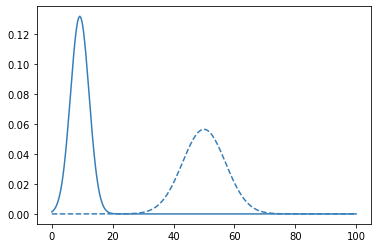

In [15]:
plt.plot(g,p0_unreg_sHigh,c=CB_colors[0],ls='--')
plt.plot(g,p_unreg_sHigh,c=CB_colors[0])

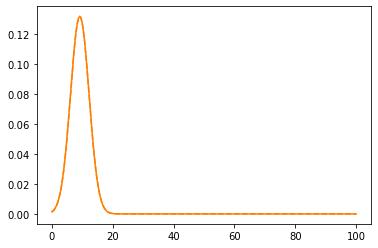

In [16]:
plt.plot(g,p0_reg_sHigh,c=CB_colors[1],ls='--')
plt.plot(g,p_reg_sHigh,c=CB_colors[1])

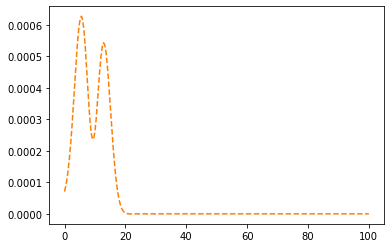

In [17]:
plt.plot(g,p_reg_sHigh-p0_reg_sHigh,c=CB_colors[1],ls='--')
# plt.plot(g,p_reg_sHigh,c=CB_colors[1])

In [27]:
# #Fitness and population distributions as a function of g:
# fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=[9.6,4.8])

# # ax[0].plot(g,p0_unreg_sLow,color=CB_colors[0],label='no reg.')
# ax[0].fill_between(g,y1=p0_unreg_sLow,y2=0,color=CB_colors[0],alpha=1,label='no reg.')
# # ax[0].plot(g, p0_reg_sLow,color=CB_colors[1],label='with reg.')
# ax[0].fill_between(g,y1=p0_reg_sLow,y2=0,color=CB_colors[1],alpha=0.5,label='with reg.')
# ax[0].axvline(g_reg_sLow,color='k',linestyle=':')
# ax[0].tick_params(axis='both', which='major', labelsize=12)
# ax[0].tick_params(axis='both', which='minor', labelsize=10)
# ax02 = ax[0].twinx()
# ax02.plot(g,fitness(g,sug_low,delta),'k--')
# ax02.set_yticks([])
# ax02.tick_params(axis='both', which='major', labelsize=12)
# ax02.tick_params(axis='both', which='minor', labelsize=10)
# ax[0].legend(loc='best',fontsize=12)
# ax[0].set_title('Low sugar',fontsize=18)

# ax[1].fill_between(g,y1=p0_unreg_sHigh,y2=0,color=CB_colors[0],alpha=1)
# ax[1].fill_between(g,y1=p0_reg_sHigh,y2=0,color=CB_colors[1],alpha=0.5)
# ax[1].tick_params(axis='both', which='major', labelsize=12)
# ax[1].tick_params(axis='both', which='minor', labelsize=10)
# # ax[1].set_yticks([])
# ax12 = ax[1].twinx()
# ax12.plot(g,fitness(g,sug_high,delta),color='k',ls='dashed',label='fitness')
# ax12.axvline(g_reg_sHigh,color='k',linestyle=':',label=r'opt. $g$')
# ax12.legend(loc='best',fontsize=12)
# ax12.tick_params(axis='both', which='major', labelsize=12)
# ax12.tick_params(axis='both', which='minor', labelsize=10)
# ax[1].set_title('High sugar',fontsize=18)

# ax02.get_shared_y_axes().join(ax02, ax12)

# fig.text(0.5, 0.03, r"Gene expression $g$", ha='center', va='center', fontsize=18)
# fig.text(0.03, 0.5, "Probability", ha='center', va='center', rotation='vertical', fontsize=18)
# fig.text(0.97, 0.5, "Fitness", ha='center', va='center', rotation=270, fontsize=18)
# fig.text(0.5, 1.01, r"Fitness function and population $g$ distribution vs. $g$", ha='center', va='center', rotation=0, fontsize=20)

# plt.subplots_adjust(wspace=0)

# fig.savefig("1_pop_distributions.pdf",format="pdf",dpi=2000,bbox_inches="tight",pad_inches=0.05)

In [17]:
# #Plotting fitness as a function of s:
# sug_arr = np.arange(50,600,0.1)
# #Fitnesses
# fit_unreg_arr = np.zeros_like(sug_arr)
# fit_reg_arr = np.zeros_like(sug_arr)

# #The unregulated distribution, purely a function of alpha:
# p0_unreg_sug = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
# p0_unreg_sug = p0_unreg_sug/np.trapz(p0_unreg_sug,dx=dg)

# #Calculating fitness for various
# for sug_idx in range(len(sug_arr)):
#     #The sugar
#     sug = sug_arr[sug_idx]
#     #Fitness and the optimal expression value:
#     fit_sug = fitness(g,sug,delta)
#     g_reg_sug = g[np.argmax(fit_sug)]
#     p0_reg_sug = Gaussian(g,g_reg_sug,np.maximum(np.sqrt(alpha*g_reg_sug),1))
#     p0_reg_sug = p0_reg_sug/np.trapz(p0_reg_sug,dx=dg)
    

50.0
